In [1]:
MONK_TASK = 1
USER = 'Paolo'

In [2]:
import sys
import os
if (colab := 'google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = "/content/drive/Shareddrives/Project_ML_23/" + USER + "/machine-learning-project"
    sys.path.insert(0,BASE_PATH)
    sys.path.insert(0,BASE_PATH + "/src/utils")
    N_JOBS = 1
    !pip install optuna
    !pip install scikit-learn
    !pip install scikeras
    TRAIN_DATA = os.path.join(BASE_PATH, 'datasets', 'monk',f'monks-{MONK_TASK}.train')
    TEST_DATA = os.path.join(BASE_PATH, 'datasets', 'monk',f'monks-{MONK_TASK}.test')
    IMAGES_FOLDER = os.path.join(BASE_PATH, 'images', 'monk',  f'task-{MONK_TASK}', 'random_forest')
    MODEL_FOLDER = os.path.join(BASE_PATH, 'trained_models', 'monk', f'task-{MONK_TASK}')
else :
    N_JOBS = -1
    TRAIN_DATA = os.path.join('..', '..', '..', 'datasets', 'monk', f'monks-{MONK_TASK}.train')
    TEST_DATA = os.path.join('..', '..', '..', 'datasets', 'monk', f'monks-{MONK_TASK}.test')
    IMAGES_FOLDER = os.path.join('..', '..', '..', 'images', 'monk', f'task-{MONK_TASK}', 'random_forest')
    MODEL_FOLDER = os.path.join('..', '..', '..', 'trained_models', 'monk', f'task-{MONK_TASK}')

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.1 MB/s eta 0:00:00


In [3]:
if (colab := 'google.colab' in sys.modules):
    sys.path.append(BASE_PATH + "/src/utils")
else:
    sys.path.append(os.path.join('..','..', 'utils'))


import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_theme(style='darkgrid')

from utils import save_plot, set_random_state

set_random_state(42)

In [4]:
# To skip the first column (row indexes)
columns_to_read = list(range(1, 8))

df_train = pd.read_csv(TRAIN_DATA, header=None, usecols=columns_to_read, delimiter=' ')
df_test = pd.read_csv(TEST_DATA, header=None, usecols=columns_to_read, delimiter=' ')
df_train.head()

,1,2,3,4,5,6,7
0,1,1,1,1,1,3,1
1,1,1,1,1,1,3,2
2,1,1,1,1,3,2,1
3,1,1,1,1,3,3,2
4,1,1,1,2,1,2,1


In [5]:
features = ['feature_' + str(i) for i in range(1, 7)]

# Rename columns
new_column_names = ['class'] + features

df_train.columns = new_column_names
df_test.columns = new_column_names

df_train.head()

,class,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
0,1,1,1,1,1,3,1
1,1,1,1,1,1,3,2
2,1,1,1,1,3,2,1
3,1,1,1,1,3,3,2
4,1,1,1,2,1,2,1


In [6]:
df_train_encoded = pd.get_dummies(df_train, columns=features)
df_test_encoded = pd.get_dummies(df_test, columns=features)

df_train_encoded, df_test_encoded = df_train_encoded.align(df_test_encoded, join='inner', axis=1)

df_train_encoded.head()

,class,feature_1_1,feature_1_2,feature_1_3,feature_2_1,feature_2_2,feature_2_3,feature_3_1,feature_3_2,feature_4_1,feature_4_2,feature_4_3,feature_5_1,feature_5_2,feature_5_3,feature_5_4,feature_6_1,feature_6_2
0,1,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0
1,1,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1
2,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0
3,1,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1
4,1,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0


In [7]:
features = df_train_encoded.columns.difference(['class'])

X_train = df_train_encoded[features].to_numpy()
y_train = df_train_encoded['class'].to_numpy()

X_test = df_test_encoded[features].to_numpy()
y_test = df_test_encoded['class'].to_numpy()

# Create model

In [8]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42, n_jobs=-1)

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [20, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=0,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [20, 50, 100, 200]},
             scoring='accuracy')

In [10]:
from sklearn.metrics import accuracy_score, classification_report

final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test)

print('Best parameters: ', grid_search.best_params_)
print('Best accuracy: ', grid_search.best_score_)
print('Test set accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best parameters:  {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 20}
Best accuracy:  0.7803333333333333
Test set accuracy:  0.9537037037037037
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       216
           1       0.94      0.97      0.95       216

    accuracy                           0.95       432
   macro avg       0.95      0.95      0.95       432
weighted avg       0.95      0.95      0.95       432



# Learning curve

In [11]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=final_model,
    X=X_train,
    y=y_train,
    train_sizes=[0.1, 0.33, 0.55, 0.78, 1.],
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

[learning_curve] Training set sizes: [ 9 32 54 77 99]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:    1.0s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.8s finished


In [12]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

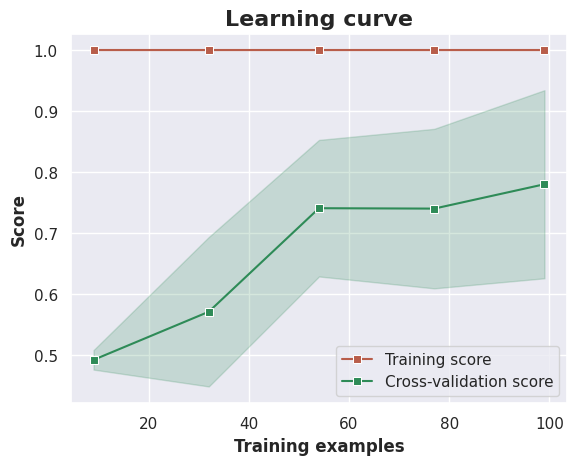

In [13]:
plt.figure()
plt.title('Learning curve', fontweight='bold', fontsize=16)
plt.xlabel('Training examples', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.grid(True)

color1 = sns.dark_palette((20, 60, 50), input='husl')[-1]
color2 = sns.dark_palette('seagreen')[-1]

# Filling the area around the mean scores to indicate variability of the model's performance
# The shaded area represents the range of scores (mean ± standard deviation) for each training set size
plt.fill_between(
    train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color=color1
)
plt.fill_between(
    train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.2, color=color2
)

# Mean score lines for training and validation
sns.lineplot(x=train_sizes, y=train_scores_mean, marker='s', color=color1, label='Training score')
sns.lineplot(x=train_sizes, y=validation_scores_mean, marker='s', color=color2, label='Cross-validation score')

plt.legend(loc='lower right')

save_plot(plt, IMAGES_FOLDER, 'learning_curve')
plt.show()

# Save model

In [14]:
from joblib import dump

model_path = os.path.join(MODEL_FOLDER, 'random_forest_model.joblib')
dump(final_model, model_path, compress=3)

['/content/drive/Shareddrives/Project_ML_23/Paolo/machine-learning-project/trained_models/monk/task-1/random_forest_model.joblib']